<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/11_Como_treinar_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Como treinar ~~o seu Dragão~~ sua Rede Neural (Profunda)**

<img align="center" width= 250 style="padding-right:100px;" src="https://br.web.img3.acsta.net/img/2c/59/2c5907be8f52c06b3cba679cd43d2ed7.jpg">



<img align="right" width= 150 style="padding-left:10px;padding-right:10px" src="https://learning.oreilly.com/library/cover/9781098125967/250w/">

O conteudo deste notebook foi obtido do capítulo 11 do livro "Mãos à obra: Aprendizado de Máquinas com Scikit-Learn, Keras & TensorFlow" do Aurélien Géron.

Os notebooks originais em inglês estão disponíveis no repositório https://github.com/ageron/handson-ml2




# Setup

Primeiro, vamos importar alguns módulos comuns, garantir que o MatplotLib plote figuras _inline_ e preparar uma função para salvar as figuras. Também verificamos se o Python 3.5 ou posterior está instalado (embora o Python 2.x possa funcionar, ele está obsoleto, por isso recomendamos fortemente que você use o Python 3), bem como o Scikit-Learn ≥0.20 e o TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Obstáculos no treinamento de Redes Neurais Profundas

Nos exemplos da aula anterior só ajustamos alguns hyperparâmetros e já conseguiamos que nossa rede neural convergisse a um resultado razoável.

Mas aquelas eram redes rasas, com apenas algumas poucas camadas ocultas. Quando precisamos lidar com um problema complexo, como detectar centenas de tipos de objetos em imagens de alta resolução, podemos precisar usar uma DNN muito mais profunda, talvez com 10 camadas ou muito mais, cada uma contendo centenas de neurônios, ligados por centenas de milhares de conexões. (Antigamente qualquer rede com pelo menos uma camada intermediária era chamada de "profunda", atualmente se tem menos de 10 dessas camadas não costuma ser classificada assim, mas a definição não é fixa)

Treinar uma DNN (rede neural profunda) não é mamão com açúcar!

Alguns problemas comumente encontrados ao treinar DNN são:
 * Gradientes que desaparecem (viram ```0```, um plateau) ou que explodem (vão aumentando rápidamente) ao fazer _backpropagation_;
 * não ter suficiente quantidade de dados para treinar (ou dados com a sua classe -label/target- assignada corretamente);
 * o treino demora muito ou consome muitos recursos computacionais;
 * rede com muitos parâmetros e poucas instâncias utilizadas no treinamento trazem um risco de _overfitting_.



# Problema de Gradientes que Desaparecem ou Explodem

Primeiro, lembremos que um dos autores do [mêtodo de _backpropagation_](https://www.nature.com/articles/323533a0), Geoffrey Hinton, foi ganhador do premio Nobel de Física de 2024 junto com John Hopfield, criador de uma arquitetura de rede neural recorrente inspirada em física de matéria condensada, a [Rede de Hopfield](https://en.wikipedia.org/wiki/Hopfield_network).

O mêtodo de backpropagation precisa que as funções de ativação das redes neurais sejam diferenciáveis (para terem gradientes para calcular), então o que no perceptron original era uma Heaviside (_Step_) que precisa mudar para sigmoide, tangente hyperbólica, _softmax_, ReLU (_Rectified Linear Unit_), etc.
Outro detalhe importante de notar é que os pesos iniciais da rede devem ter valores aleatórios para poder começar o treinamento e aprendizado.


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

def softmax(z) :
  x2=np.linspace(-2,2,200) #x2 is another input or output for multiclass for example, in this case correlated to z
  return np.exp(z)/(np.exp(z)+np.exp(x2))

Saving figure activation_functions_plot


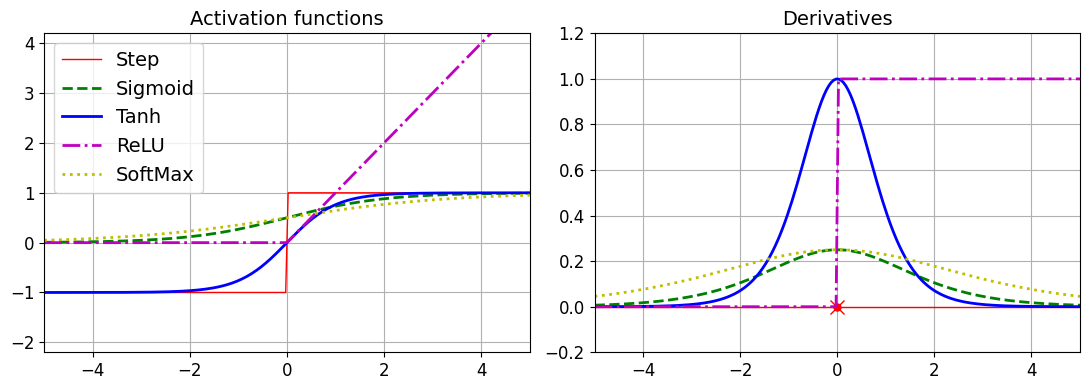

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, softmax(z), "y:", linewidth=2, label="SoftMax")
plt.grid(True)
plt.legend(loc="upper left", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -2.2, 4.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, derivative(softmax, z), "y:", linewidth=2, label="SoftMax")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

Mas um problema com as funções e ativação como a Sigmoide e a Tanh é que tem uma parte que o regime é quase *linear* (e com a derivada bem definida) e tem os extremos onde satura (se o output esta perto de 0 ou de 1, a derivada se aproxima a zero).

Saving figure sigmoid_saturation_plot


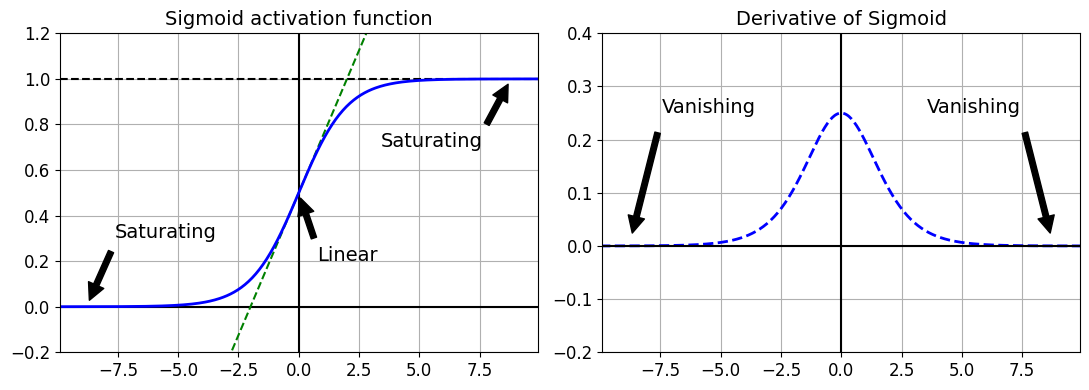

In [ ]:
z = np.linspace(-10, 10, 400)
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot([-9.9, 9.9], [0, 0], 'k-')
plt.plot([-9.9, 9.9], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(5.5, 0.7), xy=(8.8, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-5.5, 0.3), xy=(-8.8, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-9.9, 9.9, -0.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(sigmoid, z), "b--", linewidth=2, label="Sigmoid")
plt.annotate('Vanishing', xytext=(-5.5, 0.25), xy=(-8.8, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Vanishing', xytext=(5.5, 0.25), xy=(8.8, 0), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Derivative of Sigmoid", fontsize=14)
plt.plot([0, 0], [-0.2, 0.5], 'k-')
plt.plot([-9.9, 9.9], [0, 0], 'k-')
plt.axis([-9.9, 9.9, -0.2, 0.4])
save_fig("sigmoid_saturation_plot")
plt.show()

Nos extremos, onde as derivadas se aproximam mais e mais a zero, os gradientes calculados na "descida do gradiente" podem ficar anulados, e como  são usados para atualizar os pesos, podem  um neurônio pode ficar travado com os pesos em um valor que não pode mais melhorar.

## Inicialização de Xavier (Glorot) e de (Kaiming) He

Para mitigar o problema dos gradientes que se anulam, a forma de escolher aleatóriamente os pesos iniciais dos neurônios da rede vai fazer uma diferença.
Usando pequenos truques estatísticos na distribuição aleatória dos pesos iniciais, é  poseivel  evitar que os gradientes se anulem.

Por exemplo ao utilizar a sigmoide, se os pesos iniciais aleatórios simplesmente seguissem uma normal padrão (média em zero e variância igual a 1), a rede começa saturar nas camadas finais, e ao propagar para atualizar os pesos as camadas iniciais não tem quase atualização, e não conseguem mais aprender.

Algumas soluções propostas originalmente nos artigos [Glorot & Bengio, 2010](https://proceedings.mlr.press/v9/glorot10a/) e [He et al., 2015](https://doi.org/10.48550/arXiv.1502.01852) demostram como variar a forma de inicializar os pesos vai ajudar a rede aprender melhor. O que muda é a função de distribuição dos pesos iniciais da rede.




A distribuição proposta por Glorot é uma normal com  média 0 e variância

$\sigma^2 = \dfrac{1}{\mathrm{fan}_{avg}}$

onde

$\mathrm{fan}_{avg} = \dfrac{\mathrm{fan}_{in}+\mathrm{fan}_{out}}{2}$

é a média entre o número de inputs ($\mathrm{fan}_{in}$) e o número de neurônios (ou outputs $\mathrm{fan}_{out}$),  de uma camada.

(Ou pode se escolher uma distribuição uniforme no intervalo $\left[-3\sigma^2,3\sigma^2\right]$ ).


Para a função de ativação ReLU (e seus similares) a distribuição dos pesos iniciais deve seguir uma normal com média 0 e variância $\sigma^2 = \dfrac{2}{\mathrm{fan}_{in}}$

A lista com todas as implementações disponíveis no KERAS para inicializar pesos e _biases_ pode ser obtida assim:

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'IdentityInitializer',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'OrthogonalInitializer',
 'RandomNormal',
 'RandomUniform',
 'STFT',
 'STFTInitializer',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'stft',
 'truncated_normal',
 'variance_scaling',
 'zeros']

Para selecionar o inicializador de He na distribuição normal para uma determinada camada densa, tem que usar o parâmetro ```kernel_initializer```

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

<Dense name=dense, built=False>

Para escolher o inicializador de He com distribuição normal, mas mudando o valor da variância  para $\mathrm{fan}_{avg}$, será necessário usar a opção ```VarianceScaling```, desse jeito:

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

<Dense name=dense_1, built=False>

Para cada função de ativação, tem possíveis inicializadores que melhoram o treinamento da rede:

<img align="center" width= 550 style="padding-right:100px;" src="https://github.com/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/pics/inicializadores.png?raw=true">

## Funções de Ativação que Não Saturam




A função ReLU original tem potencial saturação para inputs negativos, ainda assim por ser rápida de computar é muito utilizada e vai servir em vários casos. Mas para melhorar a performance em redes profundas, as vezes vai ser necesário cuidar que do lado dos inputs negativos a função ainda tenha derivada não-nula.


### Leaky ReLU

Do lado dos inputs negativos tem uma leve inclinação, que é suficiente para manter o gradiente.

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

def relu(z):
  return np.maximum(0,z)



Saving figure leaky_relu_plot


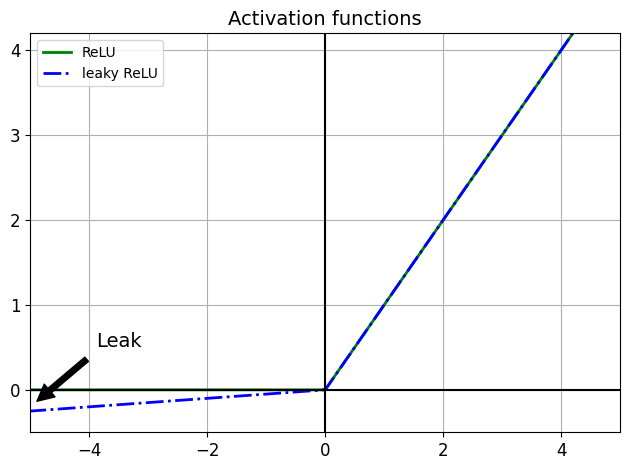

In [ ]:
plt.plot(z,relu(z),"g-", linewidth=2,label="ReLU")
plt.plot(z, leaky_relu(z, 0.05), "b-.", linewidth=2,label="leaky ReLU")

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.legend(loc="upper left")
save_fig("leaky_relu_plot")
plt.show()

A lista de todas as funções de ativacão disponíveis no Keras:

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['celu',
 'deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'glu',
 'hard_shrink',
 'hard_sigmoid',
 'hard_silu',
 'hard_swish',
 'hard_tanh',
 'leaky_relu',
 'linear',
 'log_sigmoid',
 'log_softmax',
 'mish',
 'relu',
 'relu6',
 'selu',
 'serialize',
 'sigmoid',
 'silu',
 'soft_shrink',
 'softmax',
 'softplus',
 'softsign',
 'sparse_plus',
 'sparsemax',
 'squareplus',
 'swish',
 'tanh',
 'tanh_shrink',
 'threshold']

Também pode se customizar a função de ativação usando uma função de Python (_callable_) que tenha de input um tensor e retorne um tensor com a mesma _shape_ e o mesmo ```dtype``` [(Keras site)](https://keras.io/api/layers/activations/).

As variações do ReLU disponíveis como camadas no Keras são:

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Vamos treinar uma rede neural no dataset de Fashion MNIST (imagens de itens de vestir: camisas, sapatos, etc) usando Leaky ReLU.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


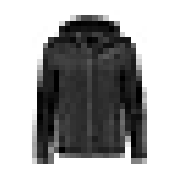

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print(class_names[y_train[0]])

Coat


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.Input([28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4845 - loss: 1.6846 - val_accuracy: 0.7144 - val_loss: 0.8783
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7270 - loss: 0.8320 - val_accuracy: 0.7670 - val_loss: 0.7101
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7738 - loss: 0.6960 - val_accuracy: 0.7910 - val_loss: 0.6354
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7943 - loss: 0.6291 - val_accuracy: 0.8056 - val_loss: 0.5900
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8063 - loss: 0.5868 - val_accuracy: 0.8132 - val_loss: 0.5589
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8152 - loss: 0.5571 - val_accuracy: 0.8190 - val_loss: 0.5362
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8206 - loss: 0.5351 - val_accuracy: 0.8258 - val_loss: 0.5187
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8255 - loss: 0

Vamos tentar PReLU: (Parametric leaky ReLU, o parâmetro $\alpha$ da inclinação do lado negativo pode ser aprendido)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model2 = keras.models.Sequential([
    keras.Input([28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4704 - loss: 1.6598 - val_accuracy: 0.7140 - val_loss: 0.8774
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7227 - loss: 0.8432 - val_accuracy: 0.7698 - val_loss: 0.7072
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7719 - loss: 0.7048 - val_accuracy: 0.7976 - val_loss: 0.6314
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7937 - loss: 0.6360 - val_accuracy: 0.8112 - val_loss: 0.5850
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8062 - loss: 0.5922 - val_accuracy: 0.8192 - val_loss: 0.5529
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8151 - loss: 0.5611 - val_accuracy: 0.8268 - val_loss: 0.5287
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8204 - loss: 0.5376 - val_accuracy: 0.8314 - val_loss: 0.5102
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8255 - loss: 0

### ELU

Exponential LU: o lado esquerdo tem uma funcão exponencial com valores negativos (substraindo 1). [Proposta em 2015](https://doi.org/10.48550/arXiv.1511.07289) pode melhorar a convergência e performance do treinamento, mas o seu calculo pode ser mais lento.

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


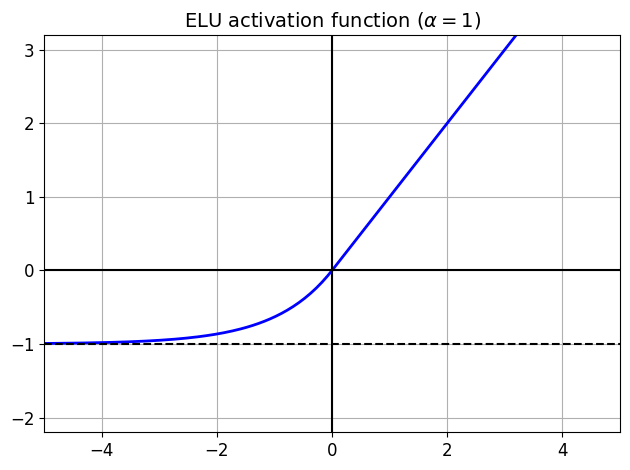

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

<Dense name=dense_6, built=False>

### SELU

Esta função de ativação foi [proposta em 2017](https://arxiv.org/pdf/1706.02515.pdf). Durante o treinamento, uma rede neural *composta exclusivamente por uma pilha de camadas densas* usando a função de ativação SELU e a inicialização de LeCun se auto-normalizará: a saída de cada camada tenderá a preservar a mesma média e variância durante o treinamento, o que resolve o problema de gradientes que desaparecem/explodem. Como resultado, esta função de ativação supera as outras funções de ativação de forma muito significativa *para as redes neurais com esta topologia*.

Infelizmente, a propriedade de auto-normalização da função de ativação SELU é facilmente quebrada (dropout, conexões de salto, recorrência, etc. vão quebrar esta propriedade). No entanto, na prática, funciona muito bem com CNNs sequenciais. Se você quebrar a auto-normalização, SELU não necessariamente superará outras funções de ativação.


In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


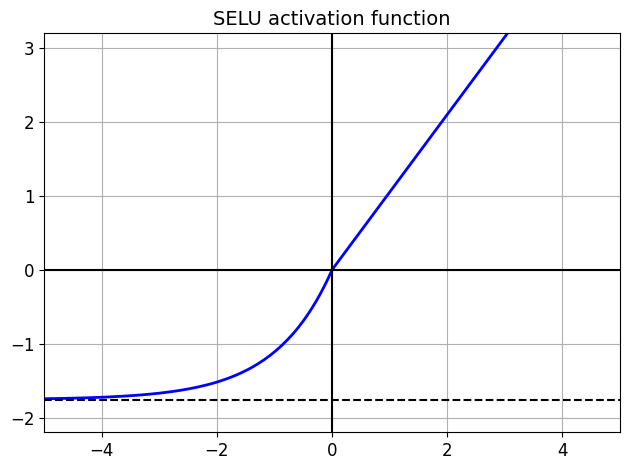

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

Por default, os hiperparâmetros da função de ativação SELU (```scale``` e ```alpha```) são ajustados de forma que a média do output de cada neurônio permaneça próxima de 0 e o desvio padrão permaneça próximo de 1, assumindo que as entradas também são padronizadas com média 0 e desvio padrão 1.

Usando essa função de ativação, mesmo uma rede neural profunda com 1.000 camadas vai manter a média ~0 e o desvio padrão ~1 em todas as camadas, evitando o problema de gradientes que explodem ou desaparecem:



In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


SELU está disponível no KERAS

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

<Dense name=dense_7, built=False>

Vamos criar uma rede para classificar os dados Fashion MNIST com 100 camadas ocultas usando SELU.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model3 = keras.models.Sequential()
model3.add(keras.Input([28,28]))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model3.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model3.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Agora, antes de treinar, **é importante escalar os inputs** para média 0 e variância 1.

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history3 = model3.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.3698 - loss: 1.5772 - val_accuracy: 0.6602 - val_loss: 0.9102
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.6862 - loss: 0.8526 - val_accuracy: 0.3988 - val_loss: 1.4423
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.5598 - loss: 1.1241 - val_accuracy: 0.6646 - val_loss: 0.8682
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.7065 - loss: 0.7821 - val_accuracy: 0.7510 - val_loss: 0.6679
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.7550 - loss: 0.6659 - val_accuracy: 0.7706 - val_loss: 0.6381


Se, invés da SELU, tentarmos usar a ReLU comum:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model0 = keras.models.Sequential()
model0.add(keras.Input([28,28]))
model0.add(keras.layers.Flatten())
model0.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model0.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model0.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model0.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history0 = model0.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 0.1841 - loss: 2.0893 - val_accuracy: 0.4240 - val_loss: 1.4190
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.3860 - loss: 1.4511 - val_accuracy: 0.4272 - val_loss: 1.2371
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.5137 - loss: 1.1261 - val_accuracy: 0.4054 - val_loss: 1.3891
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.5990 - loss: 0.9945 - val_accuracy: 0.6274 - val_loss: 0.9230
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.7022 - loss: 0.7877 - val_accuracy: 0.6938 - val_loss: 0.8352


"Not great at all, we suffered from the vanishing/exploding gradients problem." Diz o original, mas só ligeiramente: a acurária aumenta mais devagar e o loss de validacão não decresce.

# ReLU com inicializador "errado"

In [ ]:
modelVG = keras.models.Sequential()
modelVG.add(keras.layers.Input([28, 28]))
modelVG.add(keras.layers.Flatten())
modelVG.add(keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(10))))
for layer in range(99):
    modelVG.add(keras.layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(100))))
modelVG.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
modelVG.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
historyVG=modelVG.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

# Batch Normalization

A cada batch os inputs de uma camada são re-escalados e centrados em zero. Usa parámetros auxiliares ```gamma``` (escala) e ```beta```(deslocamento).

In [ ]:
modelBR = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
modelBR.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [ ]:
bn1 = modelBR.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

A média e a variância móvel estimam a média e variância populacional (ou seja de todo o conjunto de dados de treino) que precisa ser usada para as predicões ou avaliação do teste.

In [ ]:
#bn1.updates #deprecated

In [ ]:
modelBR.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
historyBR = modelBR.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6139 - loss: 1.1721 - val_accuracy: 0.8206 - val_loss: 0.5495
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7967 - loss: 0.5898 - val_accuracy: 0.8408 - val_loss: 0.4769
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8211 - loss: 0.5181 - val_accuracy: 0.8538 - val_loss: 0.4438
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8344 - loss: 0.4795 - val_accuracy: 0.8584 - val_loss: 0.4233
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8427 - loss: 0.4531 - val_accuracy: 0.8630 - val_loss: 0.4085
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8494 - loss: 0.4328 - val_accuracy: 0.8668 - val_loss: 0.3977
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8558 - loss: 0.4163 - val_accuracy: 0.8684 - val_loss: 0.3889
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8613 - loss: 0

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer has some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model4 = keras.models.Sequential([
    keras.Input([28, 28]),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model4.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history4 = model4.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.5250 - loss: 1.4607 - val_accuracy: 0.7844 - val_loss: 0.6783
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7734 - loss: 0.7070 - val_accuracy: 0.8134 - val_loss: 0.5618
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8032 - loss: 0.6034 - val_accuracy: 0.8270 - val_loss: 0.5075
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8178 - loss: 0.5501 - val_accuracy: 0.8404 - val_loss: 0.4745
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8273 - loss: 0.5154 - val_accuracy: 0.8476 - val_loss: 0.4518
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8339 - loss: 0.4902 - val_accuracy: 0.8542 - val_loss: 0.4349
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8394 - loss: 0.4703 - val_accuracy: 0.8580 - val_loss: 0.4216
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8454 - loss: 

## Gradient Clipping

O _clipping_ faz que os os gradientes na _backpropagation_ não excedam um certo limiar. Mais usada em redes neurais recorrentes onde batch normalization é mais complicado.

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

```clipvalue``` limita o valor de cada componente do vetor gradiente, mas isso pode mudar sua _direção_ no caminho de achar o mínimo. Para conservar a direção do gradiente limitando o valor se usa o parâmetro ```clipnorm``` que faz com que as componentes $\left(\theta_1,\theta_2,\theta_3,...\right)$ mantenham sua proporção e limita a grandeza $\dfrac{\sum{\theta_i^2}}{2}$.

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(43986, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.Input([28, 28]))
model_A.add(keras.layers.Flatten())
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7112 - loss: 0.8895 - val_accuracy: 0.8650 - val_loss: 0.3888
Epoch 2/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8663 - loss: 0.3780 - val_accuracy: 0.8844 - val_loss: 0.3313
Epoch 3/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8821 - loss: 0.3303 - val_accuracy: 0.8939 - val_loss: 0.3066
Epoch 4/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8897 - loss: 0.3078 - val_accuracy: 0.8991 - val_loss: 0.2912
Epoch 5/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8954 - loss: 0.2935 - val_accuracy: 0.9028 - val_loss: 0.2809
Epoch 6/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8990 - loss: 0.2830 - val_accuracy: 0.9056 - val_loss: 0.2735
Epoch 7/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9018 - loss: 0.2748 - val_accuracy: 0.9068 - val_loss: 0.2678
Epoch 8/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9040 - loss: 0.

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.Input([28, 28]))
model_B.add(keras.layers.Flatten())
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
historyB = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3773 - loss: 0.8610 - val_accuracy: 0.5953 - val_loss: 0.6932
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6460 - loss: 0.6428 - val_accuracy: 0.7110 - val_loss: 0.5603
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7562 - loss: 0.5079 - val_accuracy: 0.7860 - val_loss: 0.4614
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8608 - loss: 0.4073 - val_accuracy: 0.8448 - val_loss: 0.3867
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9129 - loss: 0.3328 - val_accuracy: 0.8945 - val_loss: 0.3311
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9488 - loss: 0.2787 - val_accuracy: 0.9168 - val_loss: 0.2886
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9602 - loss: 0.2380 - val_accuracy: 0.9371 - val_loss: 0.2555
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9931 - loss: 0.2066 - val_accuracy: 0.9523 - val_loss: 0.2294


In [ ]:
model_B.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_441 (Dense)               │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,803 (1.05 MB)

 Trainable params: 275,801 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
historyBA = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
historyBA2 = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8921 - loss: 0.3453 - val_accuracy: 0.8854 - val_loss: 0.3358
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9165 - loss: 0.3160 - val_accuracy: 0.9087 - val_loss: 0.3111
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9362 - loss: 0.2910 - val_accuracy: 0.9239 - val_loss: 0.2898
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9362 - loss: 0.2695 - val_accuracy: 0.9320 - val_loss: 0.2713
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9615 - loss: 0.2345 - val_accuracy: 0.9706 - val_loss: 0.1975
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9850 - loss: 0.1687 - val_accuracy: 0.9797 - val_loss: 0.1617
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9887 - loss: 0.1358 - val_accuracy: 0.9848 - val_loss: 0.1386
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9887 - loss: 0.1146 - val_accuracy: 0.9868 - val_loss: 0.1220
Epoc

So, what's the final verdict?

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9851 - loss: 0.1087


[0.10952219367027283, 0.9825000166893005]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0896


[0.08823680877685547, 0.9865000247955322]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.9!
(Por alguma razão meus números deram diferentes, e deixei os seeds iguais, vou ver, mas neste caso deu um fator apenas um pouco maior do que 1).

In [ ]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718

MAAAAAS Atenção, o autor fez trapaça, só funciona porque ele escolheu um exemplo que funcionava. Em geral o _transfer_ deveria funcionar com redes que tem alguma coisa em comum, como reconhecer elementos (rostos, itens) em uma imagem grande que contenha varias dessas imagens.

# Faster Optimizers

<img align="center" width= 550 style="padding-right:100px;" src="https://github.com/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/pics/otimizadores.png?raw=true">

## Momentum optimization

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7960 - loss: 3.2194 - val_accuracy: 0.8364 - val_loss: 0.7081
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8220 - loss: 0.7293 - val_accuracy: 0.8438 - val_loss: 0.6833


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7982 - loss: 3.3216 - val_accuracy: 0.8406 - val_loss: 0.7064
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8239 - loss: 0.7279 - val_accuracy: 0.8446 - val_loss: 0.6844


## Dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7608 - loss: 0.7364 - val_accuracy: 0.8658 - val_loss: 0.3695
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8406 - loss: 0.4317 - val_accuracy: 0.8756 - val_loss: 0.3446


## Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7133 - loss: 0.7995 - val_accuracy: 0.8504 - val_loss: 0.5412
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7942 - loss: 0.5646 - val_accuracy: 0.8480 - val_loss: 0.5314
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8033 - loss: 0.5322 - val_accuracy: 0.8504 - val_loss: 0.5247
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8113 - loss: 0.5094 - val_accuracy: 0.8566 - val_loss: 0.4866
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8169 - loss: 0.4951 - val_accuracy: 0.8668 - val_loss: 0.4477
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8223 - loss: 0.4773 - val_accuracy: 0.8638 - val_loss: 0.4411
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8239 - loss: 0.4754 - val_accuracy: 0.8672 - val_loss: 0.4456
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.8249 - loss:

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8667 - loss: 0.4835


[0.4929499626159668, 0.864799976348877]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8817 - loss: 0.3551


[0.3584666848182678, 0.8827090859413147]

In [ ]:
history = model.fit(X_train_scaled, y_train)

## MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.54, 0.  , 0.46]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.31, 0.  , 0.39]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.27, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.03, 0.  , 0.91]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.25, 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.17, 0.  , 0.73]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.35, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.14, 0.  , 0.79]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.22, 0.  , 0.26]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

np.float64(0.8697)

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_alpha_dropout                │ (None, 784)            │             0 │
│ (MCAlphaDropout)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_alpha_dropout_1              │ (None, 300)            │             0 │
│ (MCAlphaDropout)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_alpha_dropout_2              │ (None, 100)            │             0 │
│ (MCAlphaDropout)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.11, 0.  , 0.82]],
      dtype=float32)

## Max norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8050 - loss: 0.5645 - val_accuracy: 0.8650 - val_loss: 0.3650
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8675 - loss: 0.3685 - val_accuracy: 0.8716 - val_loss: 0.3551


# Exercises

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

The model with the lowest validation loss gets about 47.6% accuracy on the validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

* *Is the model converging faster than before?* Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

In [ ]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

We get 47.9% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

The model reaches 48.9% accuracy on the validation set. That's very slightly better than without dropout (47.6%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

We get no accuracy improvement in this case (we're still at 48.9% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.